# Linear 2D solution

## Init symbols for *sympy*

In [26]:
from sympy import *
from geom_util import *
from sympy.vector import CoordSys3D
import matplotlib.pyplot as plt
import sys
sys.path.append("../")

%matplotlib inline

%reload_ext autoreload
%autoreload 2
%aimport geom_util

In [27]:
# Any tweaks that normally go in .matplotlibrc, etc., should explicitly go here
%config InlineBackend.figure_format='retina'
plt.rcParams['figure.figsize'] = (12, 12)

plt.rc('text', usetex=True)
    
plt.rc('font', family='serif')

init_printing()

In [28]:
N = CoordSys3D('N')
alpha1, alpha2, alpha3 = symbols("alpha_1 alpha_2 alpha_3", real = True, positive=True)
A,K,rho = symbols("A K rho")

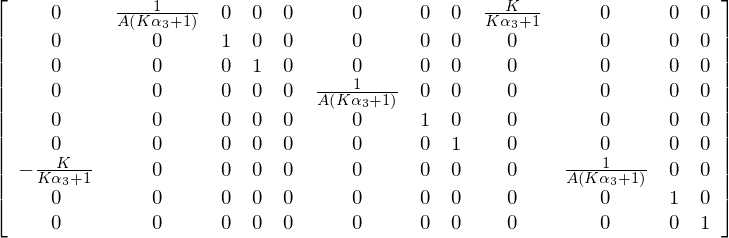

In [29]:
B=Matrix([[0, 1/(A*(K*alpha3 + 1)), 0, 0, 0, 0, 0, 0, K/(K*alpha3 + 1), 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1/(A*(K*alpha3 + 1)), 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [-K/(K*alpha3 + 1), 0, 0, 0, 0, 0, 0, 0, 0, 1/(A*(K*alpha3 + 1)), 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])
B

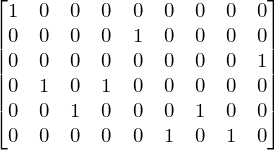

In [30]:
E=zeros(6,9)
E[0,0]=1
E[1,4]=1
E[2,8]=1
E[3,1]=1
E[3,3]=1
E[4,2]=1
E[4,6]=1
E[5,5]=1
E[5,7]=1
E

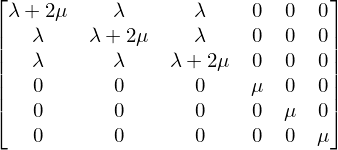

In [31]:
mu = Symbol('mu')
la = Symbol('lambda')
C_tensor = getIsotropicStiffnessTensor(mu, la)
C = convertStiffnessTensorToMatrix(C_tensor)
C

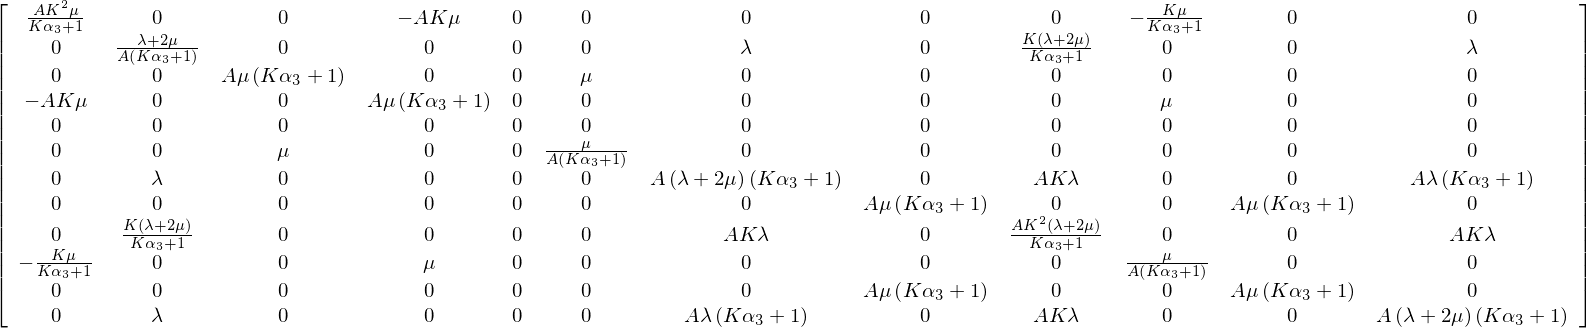

In [32]:
S=B.T*E.T*C*E*B*A*(1+alpha3*K)
S

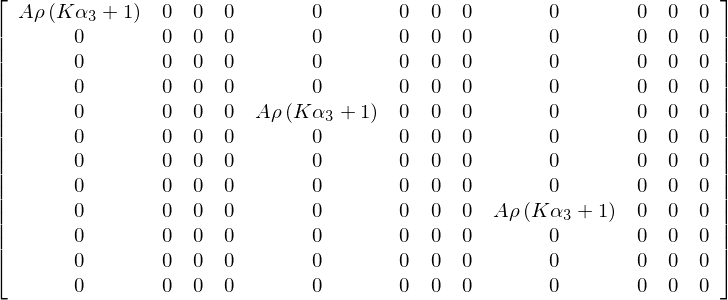

In [33]:
M=Matrix([[rho, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, rho, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, rho, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
M=M*A*(1+alpha3*K)
M

## Cartesian coordinates

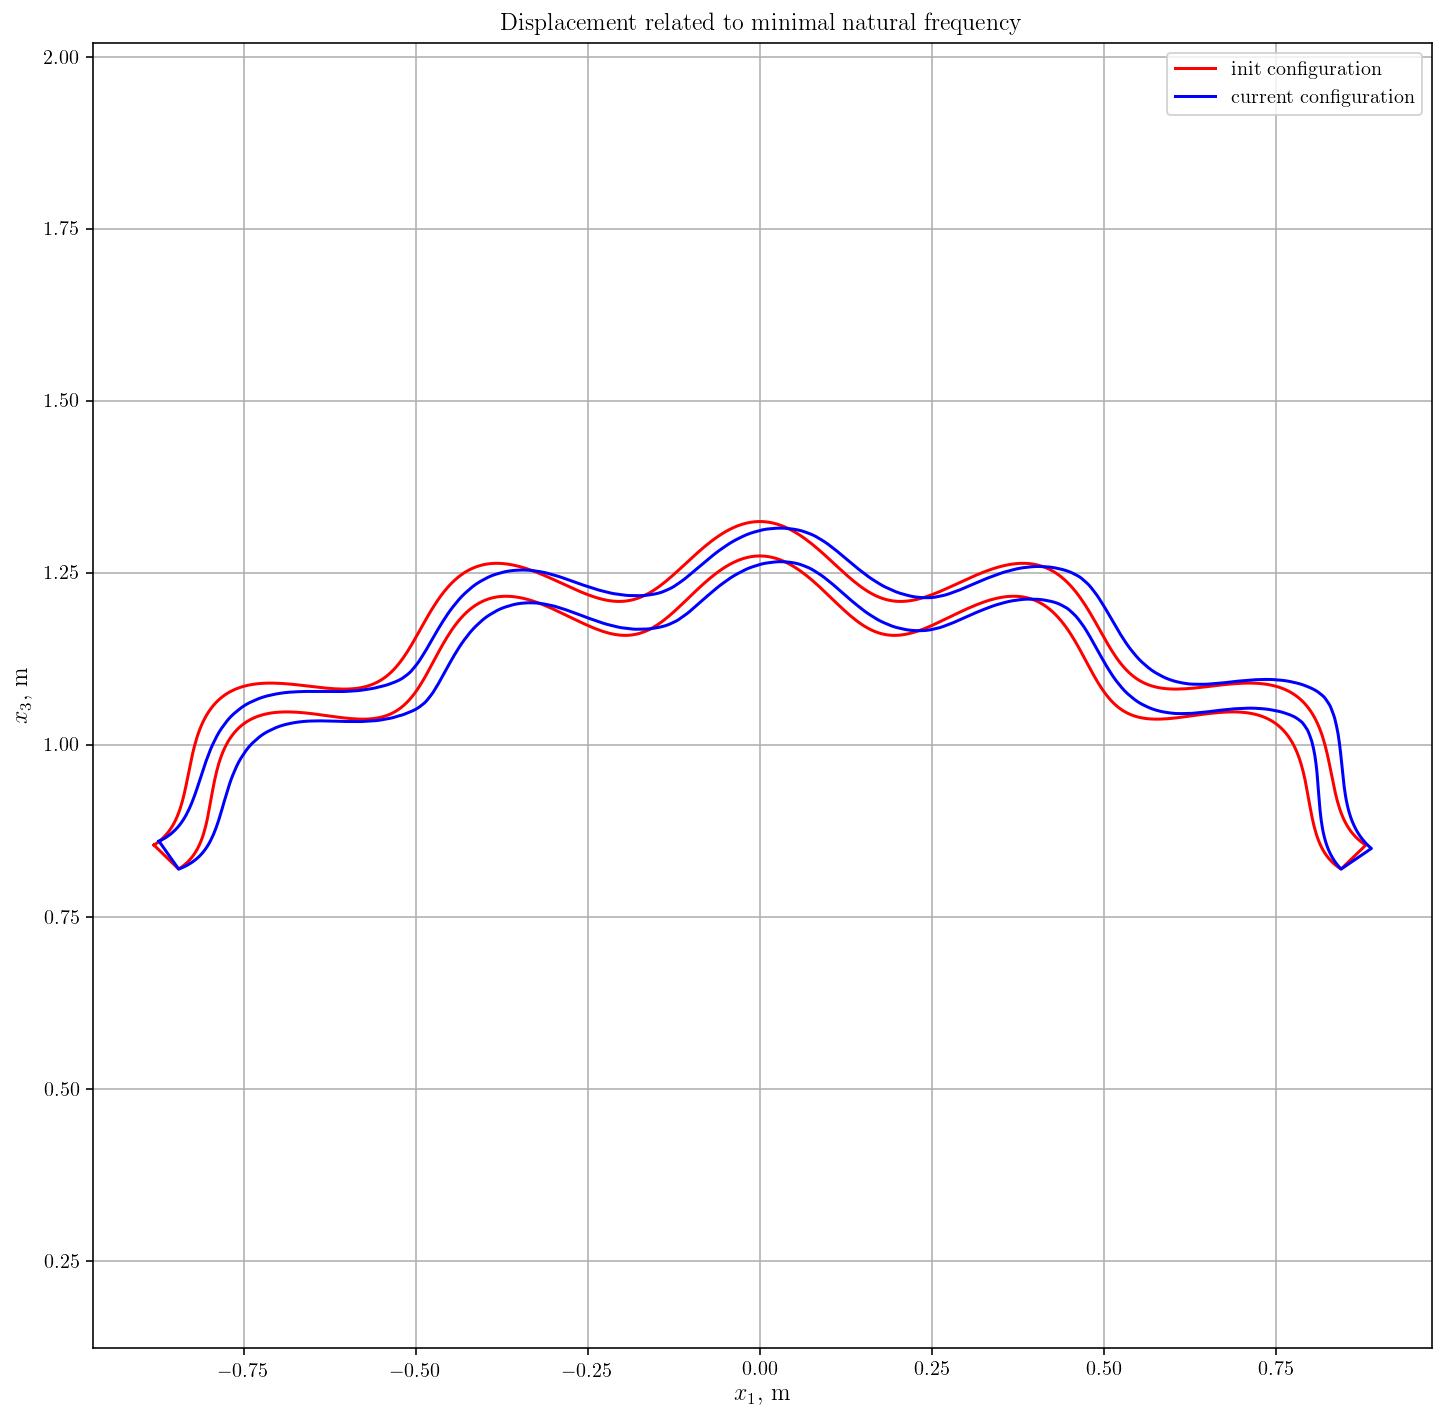

587.069111494
677.684645668
721.589584437
755.312360317
839.065189352
890.457367202
1050.17579221
1060.54750049
2206.36722196
2216.46961964
2476.35880535
2531.1126582
2851.30896921
3287.036083
3584.31575697
4150.40572278
4493.56605928
4945.97726552
5515.08160277
6075.63030733


In [35]:
import fem.geometry as g
import fem.model as m
import fem.material as mat
import fem.solver as s
import fem.mesh as me
import plot

stiffness_matrix_func = lambdify([A, K, mu, la, alpha3], S, "numpy")
mass_matrix_func = lambdify([A, K, rho, alpha3], M, "numpy")


def stiffness_matrix(material, geometry, x1, x2, x3):
    A,K = geometry.get_A_and_K(x1,x2,x3)
    return stiffness_matrix_func(A, K, material.mu(), material.lam(), x3)

def mass_matrix(material, geometry, x1, x2, x3):
    A,K = geometry.get_A_and_K(x1,x2,x3)
    return mass_matrix_func(A, K, material.rho, x3)



def generate_layers(thickness, layers_count, material):
    layer_top = thickness / 2
    layer_thickness = thickness / layers_count
    layers = set()
    for i in range(layers_count):
        layer = m.Layer(layer_top - layer_thickness, layer_top, material, i)
        layers.add(layer)
        layer_top -= layer_thickness
    return layers


def solve(geometry, thickness, linear, N_width, N_height):
    layers_count = 1
    layers = generate_layers(thickness, layers_count, mat.IsotropicMaterial.steel())
    model = m.Model(geometry, layers, m.Model.FIXED_BOTTOM_LEFT_RIGHT_POINTS)
    mesh = me.Mesh.generate(width, layers, N_width, N_height, m.Model.FIXED_BOTTOM_LEFT_RIGHT_POINTS)
    lam, vec = s.solve(model, mesh, stiffness_matrix, mass_matrix)
    return lam, vec, mesh, geometry


width = 2
curvature = 0.8
thickness = 0.05

corrugation_amplitude = 0.05
corrugation_frequency = 20

geometry = g.General(width, curvature, corrugation_amplitude, corrugation_frequency)

N_width = 100
N_height = 4


lam, vec, mesh, geometry = solve(geometry, thickness, False, N_width, N_height)
results = s.convert_to_results(lam, vec, mesh, geometry)

results_index = 0
    
plot.plot_init_and_deformed_geometry_in_cartesian(results[results_index], 0, width, -thickness / 2, thickness / 2, 0, geometry.to_cartesian_coordinates)    
    
to_print = 20
if (len(results) < to_print):
    to_print = len(results)
    
for i in range(to_print):
    print(results[i].rad_per_sec_to_Hz(results[i].freq))
